In [2]:
!pip install scikit-learn mnist
!pip install seaborn

Epoch 2/10, Loss: 2.3014
Epoch 4/10, Loss: 2.3010
Epoch 6/10, Loss: 2.3007
Epoch 8/10, Loss: 2.3005
Epoch 10/10, Loss: 2.3003


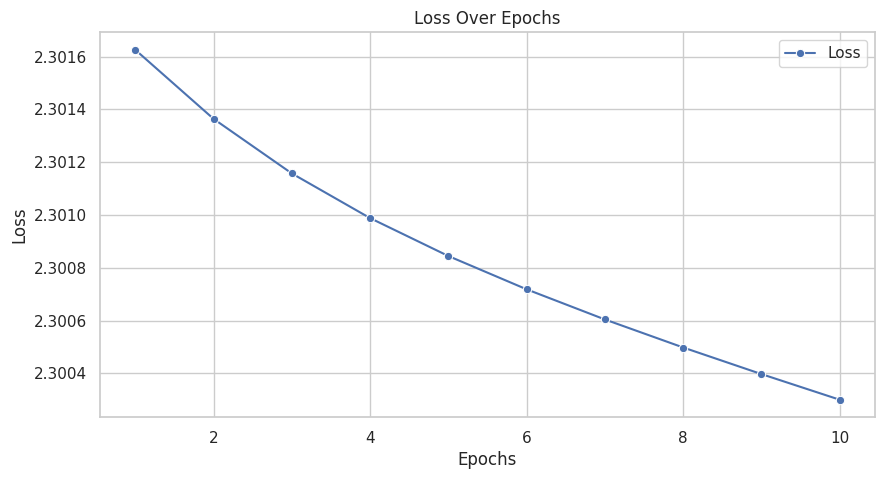

Neural Network Test Accuracy: 11.35%
KMeans Clustering Accuracy: 63.91%


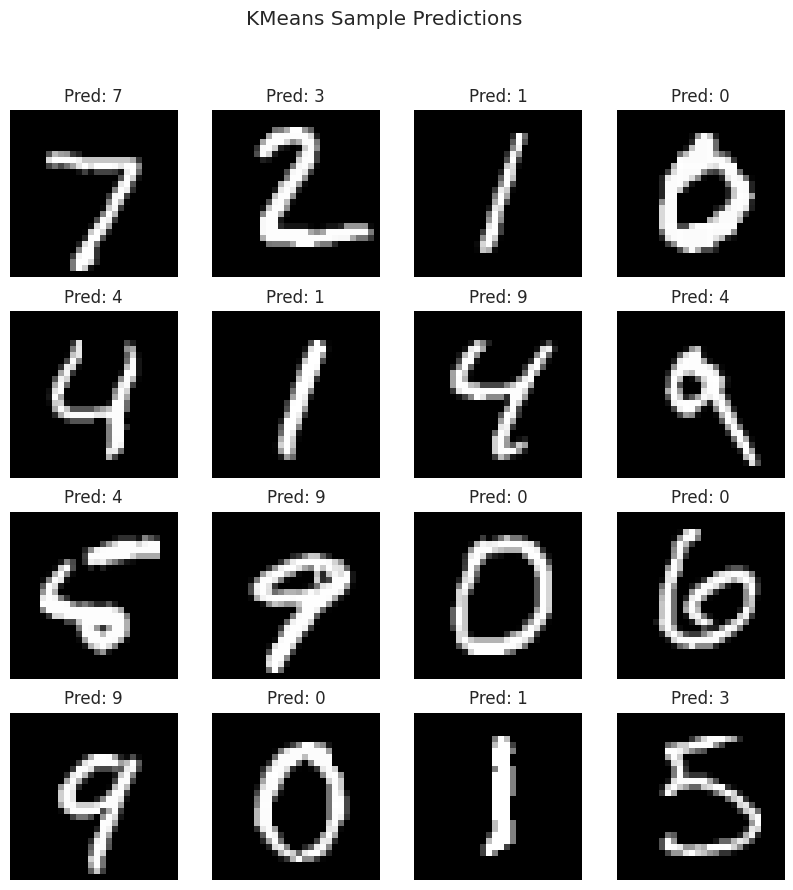

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Load MNIST dataset from sklearn's openml interface
mnist = fetch_openml('mnist_784', version=1)
x, y = mnist["data"].to_numpy(), mnist["target"].astype(np.int64).to_numpy()

# Split the data into train and test sets
x_train, x_test = x[:60000], x[60000:]
y_train, y_test = y[:60000], y[60000:]

# Preprocess the data
x_train = x_train / 255.0  # Normalize
x_test = x_test / 255.0

# Initialize neural network parameters
input_size = 784   # 28x28 images flattened
hidden_size = 64   # Number of hidden layer neurons
output_size = 10   # Number of output classes (digits 0-9)
learning_rate = 0.1
epochs = 10
losses = []  # To store loss for visualization

# Randomly initialize weights and biases
np.random.seed(42)
weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
bias_hidden = np.zeros((1, hidden_size))
weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
bias_output = np.zeros((1, output_size))

# Activation functions and derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

# Training the neural network with backpropagation
for epoch in range(epochs):
    # Forward pass
    hidden_layer_input = np.dot(x_train, weights_input_hidden) + bias_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
    predictions = softmax(output_layer_input)

    # Convert labels to one-hot encoding
    y_one_hot = np.zeros((y_train.size, output_size))
    y_one_hot[np.arange(y_train.size), y_train] = 1

    # Calculate loss (cross-entropy)
    loss = -np.mean(np.sum(y_one_hot * np.log(predictions + 1e-8), axis=1))
    losses.append(loss)  # Store loss for visualization

    # Backpropagation
    output_error = predictions - y_one_hot
    hidden_error = np.dot(output_error, weights_hidden_output.T) * sigmoid_derivative(hidden_layer_output)

    # Update weights and biases
    weights_hidden_output -= learning_rate * np.dot(hidden_layer_output.T, output_error) / x_train.shape[0]
    bias_output -= learning_rate * np.mean(output_error, axis=0, keepdims=True)
    weights_input_hidden -= learning_rate * np.dot(x_train.T, hidden_error) / x_train.shape[0]
    bias_hidden -= learning_rate * np.mean(hidden_error, axis=0, keepdims=True)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')

# Plotting the loss over epochs using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, epochs + 1), y=losses, marker='o', color='b', label='Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test data
hidden_layer_test = sigmoid(np.dot(x_test, weights_input_hidden) + bias_hidden)
output_layer_test = softmax(np.dot(hidden_layer_test, weights_hidden_output) + bias_output)
predictions_test = np.argmax(output_layer_test, axis=1)
accuracy_nn = accuracy_score(y_test, predictions_test)
print(f'Neural Network Test Accuracy: {accuracy_nn * 100:.2f}%')

# KMeans clustering on MNIST dataset
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(x_train)

# Map each cluster to the most common digit in that cluster
cluster_mapping = {}
for i in range(10):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    most_common_label = np.bincount(y_train[cluster_indices]).argmax()
    cluster_mapping[i] = most_common_label

# Predict with KMeans and map clusters to labels
kmeans_labels = kmeans.predict(x_test)
kmeans_digit_predictions = np.vectorize(cluster_mapping.get)(kmeans_labels)

# Evaluate KMeans clustering accuracy
accuracy_kmeans = accuracy_score(y_test, kmeans_digit_predictions)
print(f'KMeans Clustering Accuracy: {accuracy_kmeans * 100:.2f}%')

# Visualize some sample predictions from KMeans
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {kmeans_digit_predictions[i]}")
    plt.axis("off")
plt.suptitle("KMeans Sample Predictions")
plt.show()
